In [9]:
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import multiprocessing as mp
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.utils.multiclass import unique_labels
from sklearn.base import clone
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import warnings

In [10]:
def get_most_common_el(x):
    """Function which returns most common element.

    Parameters
    ----------
    x : ndarray, shape (n_samples,)
        Array of elements.

    Returns
    -------
    o : object
        Most common element from x.
    """
    (values, counts) = np.unique(x, return_counts=True)
    o = values[np.argmax(counts)]

    return o

def entropy(p, eps=0.000001):
    """Elementwise function for calculation of entropy.

    Parameters
    ----------
    p : ndarray, shape (n_samples,)
        Array of probabilities.
    eps : float, default=1e-5
        Avoid division by zero in calculation of log2.

    Returns
    -------
    ent : float
        Value of the elementwise entropy function evaluated for each element in p.
    """
    ent = p * np.log2(p.clip(min=eps))

    return ent

In [11]:
# some example data
X, y = make_moons(n_samples=100, noise=0.1, random_state=0) # binary data

#iris = load_iris() # multi-class data
#X, y = iris.data[:, :2], iris.target
#X, y = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

In [12]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
ensemble_size=20
train_ratio=0.5
random_state=None
verbose=0
classes = unique_labels(y_train)
b_size_ = int(X_train.shape[0] * train_ratio)
ss = StratifiedShuffleSplit(n_splits=ensemble_size,train_size=b_size_,random_state=random_state)
ensemble = []
random_state = 42

In [13]:
# different estimators for UAClassifier
classifiers = {
    "5-NN": KNeighborsClassifier(5),
    "Linear SVM": SVC(kernel="linear", C=0.025, probability=True),
    "RBF SVM": SVC(gamma=1, C=1, probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Simple Neural Network" : MLPClassifier(alpha=1, max_iter=1000),
    "QDA": QuadraticDiscriminantAnalysis(),
    "LR": LogisticRegression(solver="liblinear"),
    "RF": RandomForestClassifier(n_estimators=5, random_state=random_state)
}
Plot_Legend=False

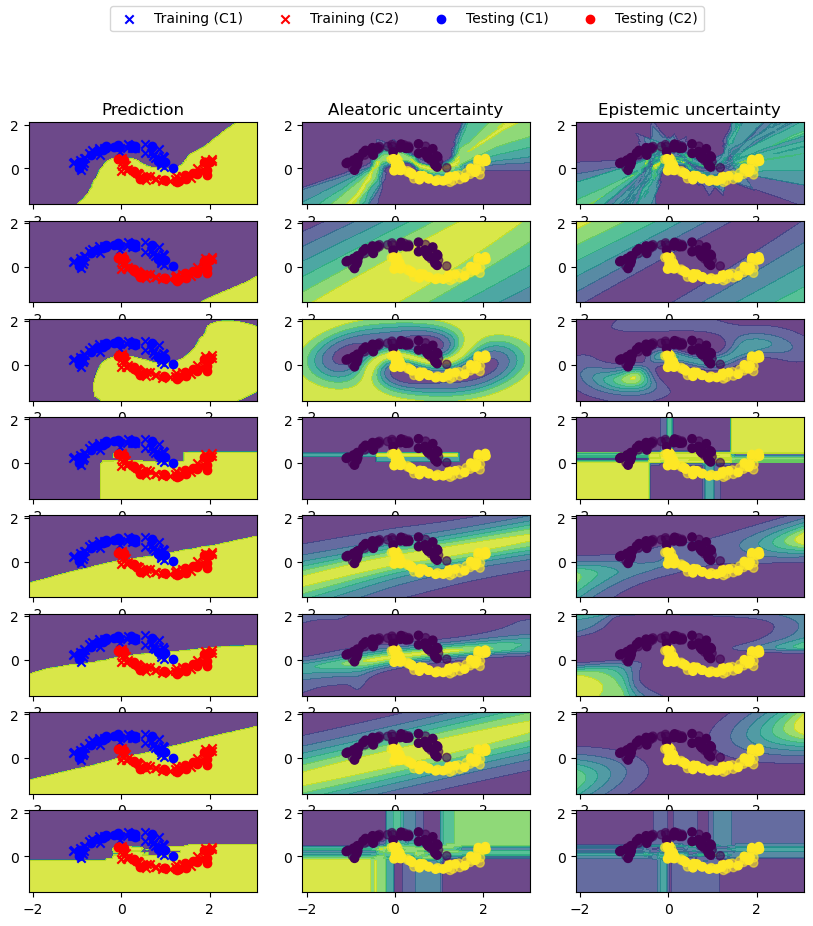

In [14]:
# create plot
cm = plt.cm.viridis
fig,ax = plt.subplots(len(classifiers), 3, figsize=(10,10))
for i, clf in enumerate(classifiers.keys()):
    
    est = classifiers[clf]
    models = []
    for train_index, _ in ss.split(X_train, y_train):
        model = {}
        # create estimator, given parameters of base estimator and bootstrap sample indices
        model["clf"] = clone(est)
        model["ind"] = train_index
        model["clf"].fit(X_train[model["ind"], :],y_train[model["ind"]],)
        models.append(model)
    #preds = clf.predict(X_test, avg=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        batch_preds = []
        for m_i in range(len(models)):
            preds = models[m_i]["clf"].predict(np.c_[xx.ravel(), yy.ravel()])
            batch_preds.append(preds.reshape((-1, 1)))
        preds = np.hstack(batch_preds)
    Zp=np.apply_along_axis(get_most_common_el, 1, preds)
    
    # obtain probabilities
    #probs = clf.predict_proba(X_test, avg=True) 
    batch_probs = []
    for m_i in range(0, len(models)):
        batch_probs.append(np.expand_dims(models[m_i]["clf"].predict_proba(np.c_[xx.ravel(), yy.ravel()]),axis=1,))
    probs = np.concatenate(batch_probs, axis=1)
    u_t = -1 * np.sum(entropy(np.mean(probs, axis=1)), axis=1)
    Za = np.mean(-1 * np.sum(entropy(probs), axis=2), axis=1)
    Ze = u_t - Za
    Zp = Zp.reshape(xx.shape)
    Za = Za.reshape(xx.shape)
    Ze = Ze.reshape(xx.shape)
    ax[i,0].contourf(xx, yy, Zp, cmap=cm, alpha=.8)
    if i == 0:
        ax[i, 0].set_title("Prediction")

    # prediction plot
    # plot the training points
    if Plot_Legend==False:
        ax[i,0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='x', label='Training (C1)')
        ax[i,0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='x', label='Training (C2)')
        if classes.shape[0]==3:
            ax[i,0].scatter(X_train[y_train==2, 0], X_train[y_train==2, 1], c='green', marker='x', label='Training (C3)')
            ax[i,0].scatter(X_test[y_test==2, 0], X_test[y_test==2, 1], c='green', marker='o', label='Testing (C3)')

        # plot the testing points
        ax[i,0].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c='blue', marker='o', label='Testing (C1)')
        ax[i,0].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='red', marker='o', label='Testing (C2)')
        Plot_Legend=True
    else:
        ax[i,0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='x')
        ax[i,0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='x')
        if classes.shape[0]==3:
            ax[i,0].scatter(X_train[y_train==2, 0], X_train[y_train==2, 1], c='green', marker='x')
            ax[i,0].scatter(X_test[y_test==2, 0], X_test[y_test==2, 1], c='green', marker='o')

        # plot the testing points
        ax[i,0].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c='blue', marker='o')
        ax[i,0].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='red', marker='o')
    
    ax[i,0].set_xlim(xx.min(), xx.max())
    ax[i,0].set_ylim(yy.min(), yy.max())

    # aleatoric uncertainty plot
    ax[i,1].contourf(xx, yy, Za, cmap=cm, alpha=.8)
    if i == 0:
        ax[i, 1].set_title("Aleatoric uncertainty")
    # plot the training points
    ax[i,1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm)
    # plot the testing points
    ax[i,1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, alpha=0.6)
    ax[i,1].set_xlim(xx.min(), xx.max())
    ax[i,1].set_ylim(yy.min(), yy.max())

    # epistemic uncertainty plot
    ax[i,2].contourf(xx, yy, Ze, cmap=cm, alpha=.8)
    if i == 0:
        ax[i, 2].set_title("Epistemic uncertainty")
    # plot the training points
    ax[i,2].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm)
    # plot the testing points
    ax[i,2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, alpha=0.6)
    ax[i,2].set_xlim(xx.min(), xx.max())
    ax[i,2].set_ylim(yy.min(), yy.max())

fig.legend(loc='upper center', ncol=4)
plt.show()